In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_absolute_error
from scipy.stats import randint, uniform
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt

# Load the datasets
df = pd.read_csv('clean_train.csv')

In [2]:
df.describe()

,id,model_year,milage,engine_power,engine_volume,engine_cylinder,gears,accident,price
count,49366.000000,49366.000000,49366.000000,49366.000000,49366.000000,49366.000000,49366.000000,49366.000000,49366.000000
mean,27119.935340,2015.316432,72351.659016,304.449824,3.654696,6.153446,3.840619,0.274926,30883.974213
std,15658.863001,4.963344,45918.174338,130.446169,1.357708,1.631309,3.710336,0.446482,19308.741586
min,0.000000,2002.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2000.000000
25%,13569.250000,2012.000000,36000.000000,240.000000,2.700000,6.000000,0.000000,0.000000,15750.000000
50%,27102.500000,2016.000000,67482.000000,302.000000,3.500000,6.000000,5.000000,0.000000,27000.000000
75%,40672.750000,2019.000000,101000.000000,385.000000,4.600000,8.000000,7.000000,1.000000,42000.000000
max,54272.000000,2024.000000,204000.000000,1020.000000,8.400000,12.000000,10.000000,1.000000,89750.000000


In [3]:
df.isnull().sum()#.info()

id                     0
brand                  0
model                  0
model_year             0
milage                 0
fuel_type            121
engine_power        3473
engine_volume        296
engine_cylinder      391
cylinder_shape     25431
engine             44199
gears              21942
transmission           3
ext_col                0
int_col                0
accident               0
clean_title            0
price                  0
dtype: int64

In [4]:
columns = ['model_year', 'milage' , 'fuel_type','engine_power', 'engine_volume','engine_cylinder','gears','transmission','accident']

In [5]:
X = df.copy()
y = X.pop("price")

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int

In [6]:
X.fillna('0',inplace=True)
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::3]  # show a few features with their MI scores

milage      0.843602
model       0.345329
brand       0.167008
int_col     0.110317
accident    0.063239
id          0.000000
Name: MI Scores, dtype: float64

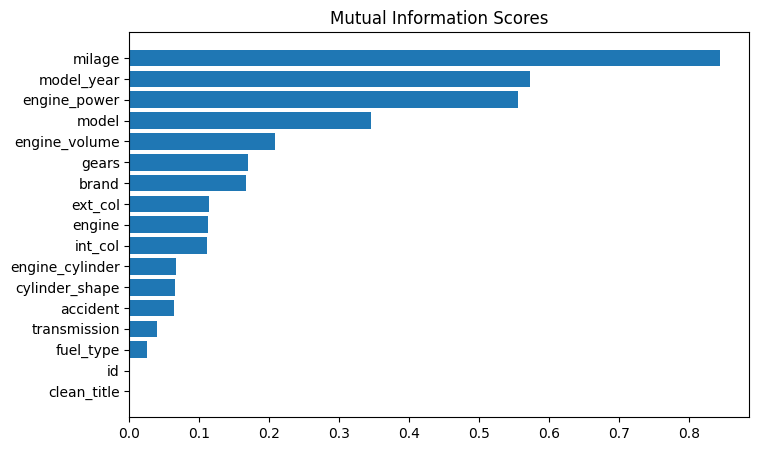

In [7]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

In [9]:
# Separate features and target variable from training data
#X = train_data.drop(['id', 'clean_title' ,'price', 'ext_col', 'int_col', 'cylinder_shape', 'gears'], axis=1)
y = df['price']   # Only the last column
X= df[columns] 

X.head()

,model_year,milage,fuel_type,engine_power,engine_volume,engine_cylinder,gears,transmission,accident
0,2018,74349,Gasoline,375.0,3.5,6.0,10.0,Automatic,0
1,2007,80000,Gasoline,300.0,3.0,6.0,6.0,Manual,0
2,2009,91491,Gasoline,300.0,4.2,8.0,6.0,Automatic,0
3,2022,2437,Hybrid,335.0,3.0,6.0,NaN,Dual-Clutch,0
4,2003,124756,Gasoline,140.0,1.8,4.0,5.0,Manual,1


In [8]:
# Automatically identify numerical and categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Define preprocessing for numerical and categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='median')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Define the model pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Define the parameter grid
param_grid = {
    'regressor__n_estimators': randint(20, 200),
    #'regressor__max_features': ['sqrt', 'log2', randint(1, len(numeric_features) + len(categorical_features))],
    'regressor__max_depth': randint(3, 20),
    'regressor__min_samples_split': randint(2, 20),
    'regressor__min_samples_leaf': randint(1, 20),
    'regressor__bootstrap': [True, False]
}

# Set up K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the scorer
scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Set up the RandomizedSearchCV
random_search = RandomizedSearchCV(
    pipeline, param_distributions=param_grid, n_iter=100,
    scoring=scorer, cv=kf, verbose=1, random_state=42, n_jobs=-1
)

# Fit the model
random_search.fit(X, y)

# Best parameters found
print(f"Best parameters: {random_search.best_params_}")

# Cross-validation scores
cv_results = random_search.cv_results_
mean_test_score = random_search.best_score_
std_test_score = cv_results['std_test_score'][random_search.best_index_]

print(f"Mean Test Score (Negative MAE): {mean_test_score}")
print(f"Standard Deviation of Test Score: {std_test_score}")

# Output predictions for inspection using the best estimator
best_model = random_search.best_estimator_
y_pred = cross_val_score(best_model, X, y, cv=kf, scoring='neg_mean_absolute_error')
print(f"Cross-Validation Scores (Negative MAE): {y_pred}")
print(f"Mean CV Score (Negative MAE): {np.mean(y_pred)}")
print(f"Standard Deviation of CV Score: {np.std(y_pred)}")


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'regressor__bootstrap': True, 'regressor__max_depth': 19, 'regressor__min_samples_leaf': 19, 'regressor__min_samples_split': 6, 'regressor__n_estimators': 136}
Mean Test Score (Negative MAE): -17150.873082062135
Standard Deviation of Test Score: 606.9939179680463
Cross-Validation Scores (Negative MAE): [-16566.88126629 -16903.09047991 -18308.30722557 -16834.60838221
 -17141.47805634]
Mean CV Score (Negative MAE): -17150.873082062135
Standard Deviation of CV Score: 606.9939179680463


In [9]:
# Step 1: Load the new dataset
test_dataset = pd.read_csv('clean_test.csv')
test_data = test_dataset[columns] 

# Ensure the new dataset has the same features as the training data
# If necessary, drop or fill any missing target column

# Step 2: Use the best_model to make predictions
y_pred = best_model.predict(test_data)

In [10]:
data  = pd.read_csv('clean_test.csv')
# Create a DataFrame with IDs and predictions
predictions = pd.DataFrame({
    'id': data.iloc[:, 0],  # Assuming the first column is the ID
    'price': y_pred
})

# Save to CSV
predictions.to_csv('.\\data\\rf_predictions.csv', index=False)